In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.tree import DecisionTreeRegressor

In [2]:
from HandsOnMachineLearningProjects.A2_CustomTransformers.ClusterSimilarity import ClusterSimilarity

In [3]:
def column_ratio(x):
    return x[:, [0]] / x[:, [1]]

In [4]:
def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

In [5]:
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

In [6]:
original_housing = pd.read_csv('../files/housing/housing.csv')
housing = original_housing.copy()
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

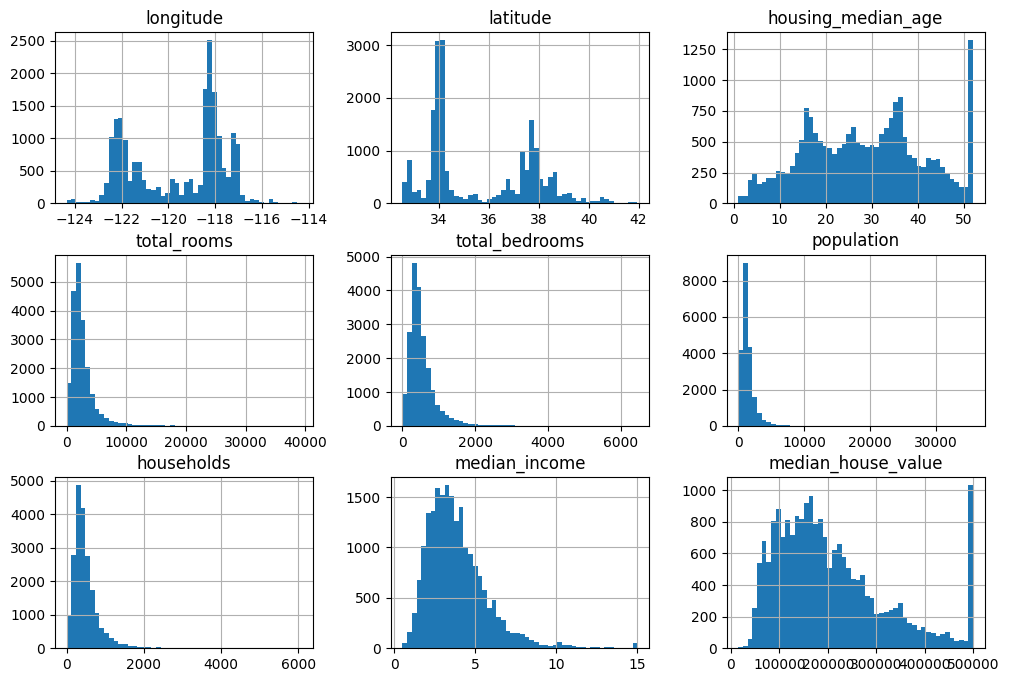

In [7]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Text(0, 0.5, 'Number Of Districts')

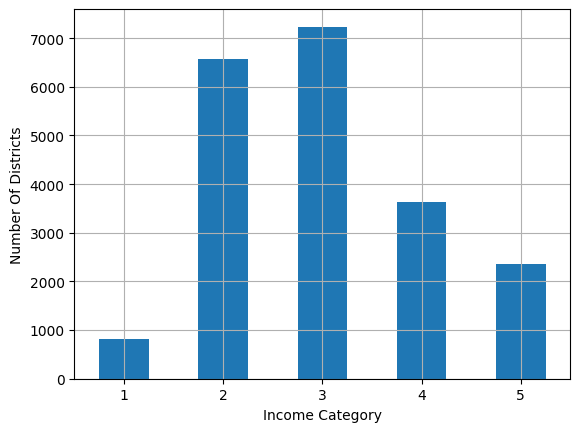

In [8]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Number Of Districts')
# plt.show()

In [9]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strata_splits = []

In [10]:
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strata_train_set_n = housing.iloc[train_index]
    strata_test_set_n = housing.iloc[test_index]
    strata_splits.append([strata_train_set_n, strata_test_set_n])

In [11]:
strata_train_set, strata_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'],
                                                     random_state=42)

In [12]:
print(strata_test_set['income_cat'].value_counts() / len(strata_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


In [13]:
for set_ in (strata_train_set, strata_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [14]:
housing = pd.DataFrame(strata_train_set.copy())

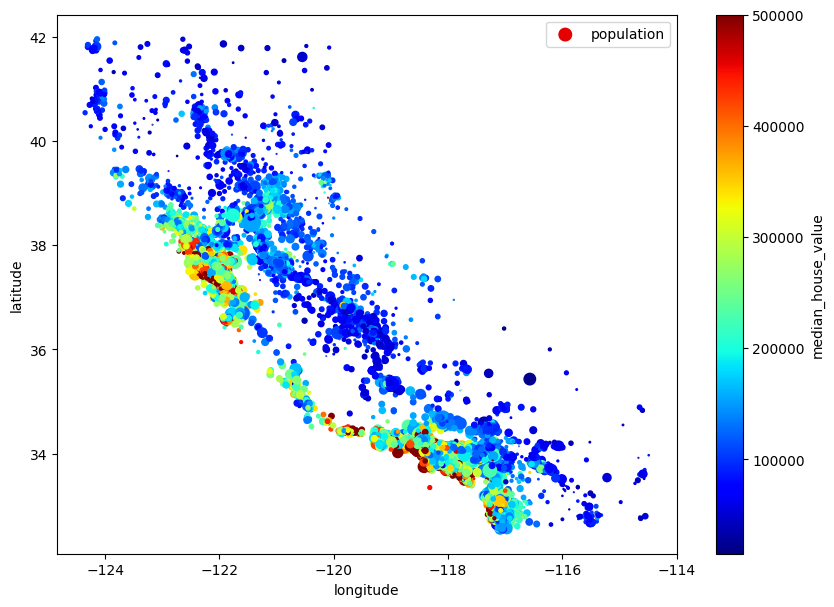

In [15]:
housing.plot(kind='scatter', x='longitude', y='latitude', s=housing['population'] / 100,
             cmap='jet', label='population', colorbar=True, c='median_house_value', sharex=False
             , figsize=(10, 7))
plt.show()

In [16]:
# we get correlation matrix to know how attributes correlates with median_housing_value
# (we correlate with median_house_value because we want to predict if sth is a good investment
# so, the more valuable attribute is median_house_value)#
corr_matrix = housing.corr()
median_house_value_correlations = corr_matrix['median_house_value']
print(median_house_value_correlations)

longitude            -0.050859
latitude             -0.139584
housing_median_age    0.102175
total_rooms           0.137455
total_bedrooms        0.054635
population           -0.020153
households            0.071426
median_income         0.688380
median_house_value    1.000000
Name: median_house_value, dtype: float64


C:\Users\rbblazquez\AppData\Local\Temp\ipykernel_27348\1218983393.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


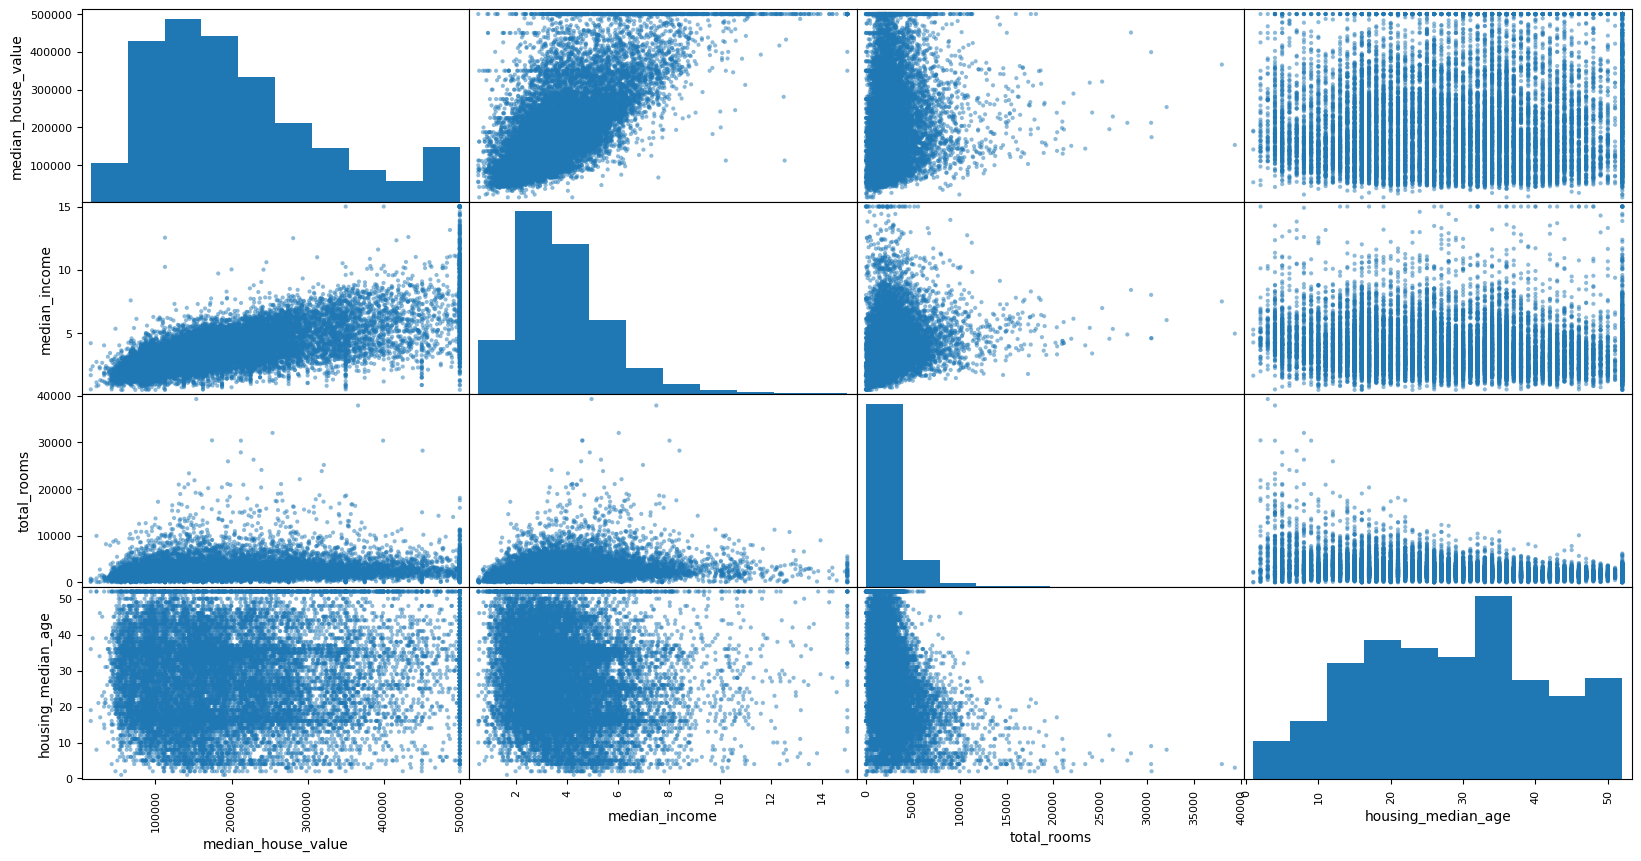

In [17]:
best_correlation_attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[best_correlation_attributes], figsize=(20, 10), grid=True)
plt.show()

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

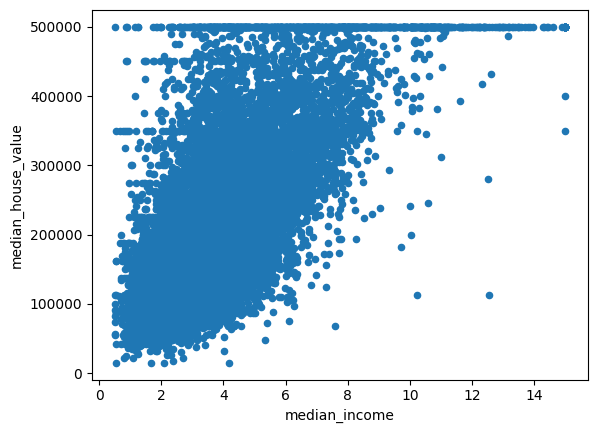

In [18]:
housing.plot(kind='scatter', x='median_income', y='median_house_value')
# plt.show()

In [19]:
# now we are going to clean data, so, first we can want to know how many rooms per house are
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']

In [20]:
# or know the number of bedrooms per room
housing['bedroom_per_room'] = housing['total_bedrooms'] / housing['total_rooms']

In [21]:
# or know how many people live in each house
housing['people_per_household'] = housing['population'] / housing['households']

In [22]:
# we get the correlations again to know if attributes calculated recently means something
corr_matrix = housing.corr()
median_house_value_correlations = corr_matrix['median_house_value']
print(median_house_value_correlations.sort_values(ascending=False))

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
people_per_household   -0.038224
longitude              -0.050859
latitude               -0.139584
bedroom_per_room       -0.256397
Name: median_house_value, dtype: float64


C:\Users\rbblazquez\AppData\Local\Temp\ipykernel_27348\2602074175.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='rooms_per_house', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='bedroom_per_room', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot: xlabel='rooms_per_house', ylabel='median_income'>,
        <AxesSubplot: xlabel='bedroom_per_room', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel='median_income', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='housing_median_ag

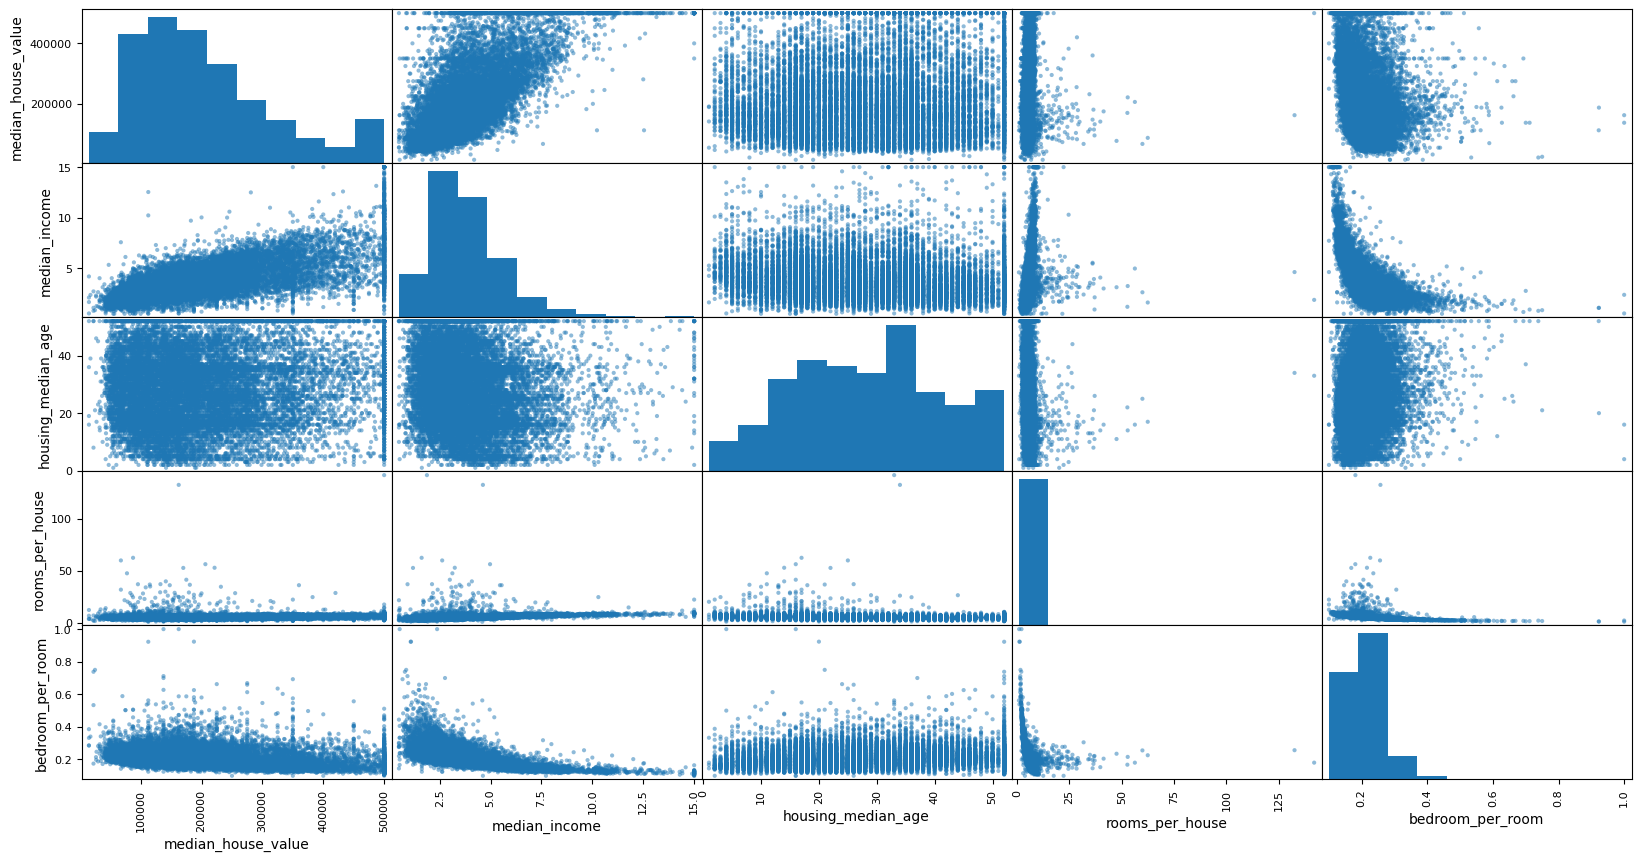

In [23]:
best_correlation_attributes = ['median_house_value', 'median_income', 'housing_median_age',
                               'rooms_per_house', 'bedroom_per_room']
scatter_matrix(housing[best_correlation_attributes], figsize=(20, 10), grid=True)
# plt.show()

In [24]:
# start cleaning, first we are going to separate train data and predict data(in our case median_house_value) so...
housing = pd.DataFrame(strata_train_set.drop(['median_house_value'], axis=1))
housing_labeled = strata_train_set['median_house_value'].copy()

In [25]:
# we fill nan values with median
simple_inputer = SimpleImputer(strategy='median')
housing_num = housing.select_dtypes(include=[np.number])
simple_inputer.fit(housing_num)

SimpleImputer(strategy='median')

In [26]:
print('median_values = ', simple_inputer.statistics_, housing_num.index)

median_values =  [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385] Int64Index([13096, 14973,  3785, 14689, 20507,  1286, 18078,  4396, 18031,
             6753,
            ...
            11877, 17004,  1894,  6234,  7071, 14207, 13105, 19301, 19121,
            19888],
           dtype='int64', length=16512)


In [27]:
new_housing = pd.DataFrame(simple_inputer.transform(housing_num), columns=housing_num.columns.values)
print(new_housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB
None


In [28]:
# clean categorical attributes(we use ordinal encoder to set one number such as 1,2,3... to category types)
housing_cat = housing[['ocean_proximity']]
# ordinal_encoder = OrdinalEncoder()
# housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# to use ordinal Encoder Variables must have a correlation between them, so ,
# we will use oneHotEncoder(to encoder variables in dummies)

In [29]:
one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)
print(housing_cat_1hot.toarray()[:8])
print('We Can Get Categories Encoded From OneHotEncoder -> ', one_hot_encoder.categories_[0])
print(len(new_housing), len(housing_cat_1hot.toarray()))
ocean_proximity_df = pd.DataFrame(housing_cat_1hot.toarray(), columns=one_hot_encoder.get_feature_names_out())
print(ocean_proximity_df.info())
new_housing_with_dummies = pd.concat([new_housing, ocean_proximity_df], axis=1)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
We Can Get Categories Encoded From OneHotEncoder ->  ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
16512 16512
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ocean_proximity_<1H OCEAN   16512 non-null  float64
 1   ocean_proximity_INLAND      16512 non-null  float64
 2   ocean_proximity_ISLAND      16512 non-null  float64
 3   ocean_proximity_NEAR BAY    16512 non-null  float64
 4   ocean_proximity_NEAR OCEAN  16512 non-null  float64
dtypes: float64(5)
memory usage: 645.1 KB
None


In [30]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_with_min_max_scaler = min_max_scaler.fit_transform(new_housing_with_dummies)
print(housing_with_min_max_scaler)
print()
standard_scaler = StandardScaler()
housing_with_standard_scaler = standard_scaler.fit_transform(new_housing_with_dummies)
print(housing_with_standard_scaler)

[[-0.60851927  0.11702128  1.         ... -1.          1.
  -1.        ]
 [ 0.21095335 -0.66170213  0.52941176 ... -1.         -1.
  -1.        ]
 [-0.51926978  0.23617021  0.25490196 ... -1.         -1.
  -1.        ]
 ...
 [ 0.47870183 -0.99148936 -0.52941176 ... -1.         -1.
   1.        ]
 [ 0.20689655 -0.6787234   0.41176471 ... -1.         -1.
  -1.        ]
 [-0.60649087  0.08723404  0.68627451 ... -1.         -1.
   1.        ]]

[[-1.42303652  1.0136059   1.86111875 ... -0.0110063   2.81864247
  -0.38057602]
 [ 0.59639445 -0.702103    0.90762971 ... -0.0110063  -0.35478072
  -0.38057602]
 [-1.2030985   1.27611874  0.35142777 ... -0.0110063  -0.35478072
  -0.38057602]
 ...
 [ 1.25620853 -1.42870103 -1.23772062 ... -0.0110063  -0.35478072
   2.62759594]
 [ 0.58639727 -0.73960483  0.66925745 ... -0.0110063  -0.35478072
  -0.38057602]
 [-1.41803793  0.94797769  1.22545939 ... -0.0110063  -0.35478072
   2.62759594]]


In [31]:
ages = np.linspace(new_housing_with_dummies["housing_median_age"].min(),
                   new_housing_with_dummies["housing_median_age"].max(),
                   500).reshape(-1, 1)

In [32]:
# now we use rbf_kernel to use radial_basis_function to cut ages in a group in a range of age 35
age_simil_35 = rbf_kernel(ages, [[35]], gamma=0.1)

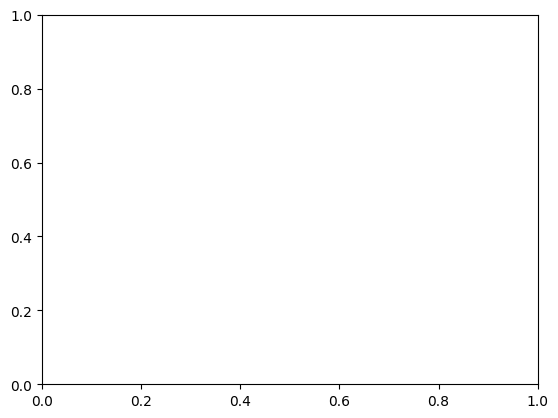

In [33]:
fig, ax1 = plt.subplots()

In [34]:
ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)
ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, age_simil_35, color=color, label="gamma = 0.10")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

Text(0, 0.5, 'Age similarity')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


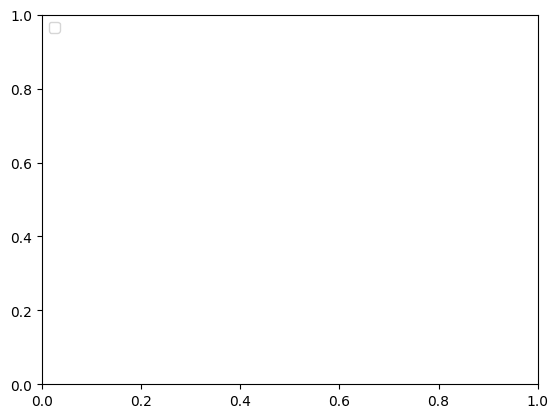

In [35]:
plt.legend(loc="upper left")
plt.show()

In [36]:
df_with_ages_between_30_and_40 = pd.DataFrame(strata_train_set.loc[
                                                  (strata_train_set['housing_median_age'] >= 30) & (
                                                          strata_train_set['housing_median_age'] <= 40)])

In [37]:
df_with_ages_between_30_and_40 = df_with_ages_between_30_and_40.reset_index()
df_with_ages_between_30_and_40.drop('index', axis=1, inplace=True)
housing_median_age = df_with_ages_between_30_and_40['housing_median_age']
prices = df_with_ages_between_30_and_40['median_house_value']

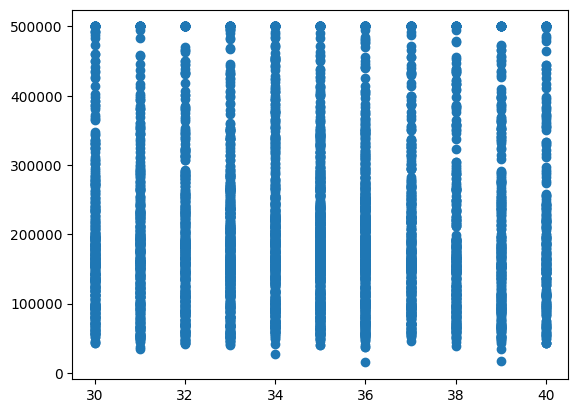

In [38]:
order = np.lexsort([prices, housing_median_age])
plt.scatter(housing_median_age[order], prices[order])
# plt.show()

In [39]:
# we can use TransformedTargetRegressor to use a linear regression and scaler in the same fit
some_new_data = housing[['median_income']].iloc[:5]
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labeled)
predictions = model.predict(some_new_data)

In [40]:
print(predictions)

[131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


In [41]:
# now we use a transformer to transform data into logarithms,
# and if you use inverse_transform you get the exponential
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [42]:
# also we can use Function Transformer to use the radial basis function mentioned before
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35_transformer = rbf_transformer.transform(ages)
# print(age_simil_35[:10], age_simil_35_transformer[0:10])

In [43]:
# use radial basis function with 2D array,
# in this case this method will do the euclidian measure between the two variable
sf_coords = 37.7749, -122.41
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = rbf_transformer.transform(housing[['latitude', 'longitude']])

In [44]:
# use multiple functions
array = np.array([[1, 2], [3, 4]])
rbf_transformer = FunctionTransformer(lambda x: x[:, [0]] / x[:, [1]])

In [45]:
print(rbf_transformer.transform(array))

[[0.5 ]
 [0.75]]


In [46]:
# we use SimpleImputer to fill null values with median, and after that we scale values
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [47]:
# if we have to encoder categorical values we will fill nun values with the most frequent
# and after that we use oneHotEncoder to transform in dummies
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder()
)

In [48]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (categorical_pipeline, make_column_selector(dtype_include='object'))
)

In [49]:
housing_with_make_column_array = preprocessing.fit_transform(original_housing)
name_columns = list(map(lambda x: x.split('__')[1], preprocessing.get_feature_names_out()))
housing_with_make_column = pd.DataFrame(housing_with_make_column_array, columns=name_columns)

In [50]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

In [69]:
cluster_simil = ClusterSimilarity(n_clusters=2, gamma=1, random_state=42)

In [70]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [71]:
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                           "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", categorical_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)

In [72]:
housing_preprocessed = pd.DataFrame(preprocessing.fit_transform(housing),
                                    columns=preprocessing.get_feature_names_out())
housing_preprocessed

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,5.875322e-01,1.180131e-15,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,7.674721e-12,8.361228e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,7.852918e-01,4.575311e-16,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,1.438143e-17,4.311865e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,8.187671e-14,9.520211e-01,0.0,0.0,0.0,0.0,1.0,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,9.586977e-13,8.516788e-01,1.0,0.0,0.0,0.0,0.0,0.987087
16508,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,2.236955e-04,6.345902e-04,0.0,1.0,0.0,0.0,0.0,-0.443146
16509,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,1.378918e-22,6.592314e-02,0.0,0.0,0.0,0.0,1.0,-1.237721
16510,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,4.732128e-12,8.448077e-01,1.0,0.0,0.0,0.0,0.0,0.669257


In [56]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labeled)
predictions = lin_reg.predict(housing)

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [57]:
print(predictions[:5].round(2), '\n', housing_labeled[:5].values.round(2))

[243624. 372376. 128672.  94336. 328304.] 
 [458300. 483800. 101700.  96100. 361800.]


In [58]:
# model determination
lin_rmse = mean_squared_error(housing_labeled, predictions, squared=False)
print(lin_rmse)

68687.95844076085


In [59]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(housing, housing_labeled)
predictions = tree_reg.predict(housing)

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [60]:
# model determination
tree_rmse = mean_squared_error(housing_labeled, predictions, squared=False)
print(11, tree_rmse)  # this produces an overfitting (its remember data used when we trained the model )

11 0.0


In [61]:
# we use this method to create 10 folds to validate the model and compare 9 to 1 with each fold
tree_rmses = -cross_val_score(tree_reg, housing, housing_labeled, scoring='neg_root_mean_squared_error', cv=10)

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

In [62]:
print('model determination Decission tree regressor', tree_rmses)

model determination Decission tree regressor [64712.67687888 65224.47097126 64303.74816933 66357.63702424
 65240.04929781 69820.4376988  68966.29098323 68840.92104069
 69800.75296609 63116.62725192]


In [63]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

In [64]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labeled, scoring='neg_root_mean_squared_error', cv=10)
print('model determination Forest regressor', pd.Series(forest_rmses).describe())

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

model determination Forest regressor count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64


In [65]:
forest_reg.fit(housing, housing_labeled)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labeled, housing_predictions,
                                 squared=False)

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print('Model error ', forest_rmse)

In [ ]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor)
])

In [ ]:
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

In [ ]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='root_mean_squared_error')
grid_search.fit(housing, housing_labeled)

In [ ]:
print(grid_search.best_params_)